### 1 对单个数字进行分类的数据预处理步骤

作者 meelo

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize
from __future__ import print_function

%matplotlib inline

选择构建训练集还是测试集

In [2]:
if True:
    dataset_type = 'train'
else:
    dataset_type = 'test'

In [3]:
filename = dataset_type + '/digitStruct.mat'
f = h5py.File(filename)

metadata= {}
metadata['height'] = []
metadata['label'] = []
metadata['left'] = []
metadata['top'] = []
metadata['width'] = []

def print_attrs(name, obj):
    vals = []
    if obj.shape[0] == 1:
        vals.append(int(obj[0][0]))
    else:
        for k in range(obj.shape[0]):
            vals.append(int(f[obj[k][0]][0][0]))
    metadata[name].append(vals)
    
for item in f['/digitStruct/bbox']:
    f[item[0]].visititems(print_attrs)

In [4]:
data_size = len(metadata['height'])

print('Data size: ', data_size)

Data size:  33402


训练数据集有一个样本的包含6个数字

In [6]:
boxes = np.zeros((data_size, 4), dtype=np.int16)
labels = np.zeros((data_size, 6), dtype=np.int8)

for i in range(len(metadata['height'])):
    top = 1000000
    bottom = 0
    left = 1000000
    right = 0
    for j in range(len(metadata['height'][i])):
        top = min(top, metadata['top'][i][j])
        left = min(left, metadata['left'][i][j])
        bottom = max(bottom, metadata['top'][i][j]+metadata['height'][i][j])
        right = max(right, metadata['left'][i][j]+metadata['width'][i][j])
    boxes[i] = [max(top,0), max(left,0), bottom, right]
    try:
        labels[i, 0] = len(metadata['label'][i])
        labels[i, 1:1+labels[i, 0]] = metadata['label'][i]
    except:
        labels[i, 1:1+labels[i, 0]] = metadata['label'][i][:5]
        print(metadata['label'][i])
    #train.append([max(top,0), max(left,0), bottom, right, metadata['label'][i]])

[1, 3, 5, 4, 5, 8]


In [8]:
labels[:10]

array([[2, 1, 9, 0, 0, 0],
       [2, 2, 3, 0, 0, 0],
       [2, 2, 5, 0, 0, 0],
       [2, 9, 3, 0, 0, 0],
       [2, 3, 1, 0, 0, 0],
       [2, 3, 3, 0, 0, 0],
       [2, 2, 8, 0, 0, 0],
       [3, 7, 4, 4, 0, 0],
       [3, 1, 2, 8, 0, 0],
       [2, 1, 6, 0, 0, 0]], dtype=int8)

In [10]:
labels[labels == 10] = 0

In [12]:
boxes[:10]

array([[ 77, 246, 300, 419],
       [ 25,  77,  61, 124],
       [  5,  17,  20,  34],
       [ 13,  57,  47,  85],
       [  7,  52,  56,  89],
       [  6,  28,  29,  49],
       [ 10,  35,  43,  60],
       [  3,  17,  19,  38],
       [  4,  19,  29,  55],
       [  4,  25,  33,  48]], dtype=int16)

Image shape before resize (31, 30, 3)
Image shape after resize (32, 32, 3)


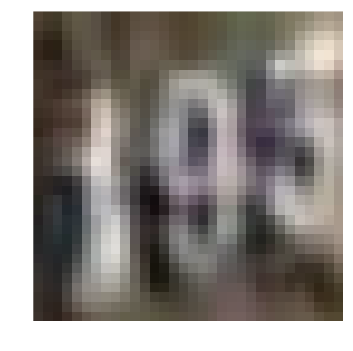

In [14]:
image_index = 91

image = plt.imread(dataset_type + '/{}.png'.format(image_index))
plt.axis('off')
top, left, bottom, right = boxes[image_index-1]
# plt.imshow(image[top:bottom, left:right], interpolation='none')
print ('Image shape before resize', image[top:bottom, left:right].shape)
image_resize = imresize(image[top:bottom, left:right], (32, 32))

plt.imshow(image_resize, interpolation='none')
print ('Image shape after resize', image_resize.shape)

异常值 bbox -1

In [15]:
def gcn(dataset):
    """Global contrast normalization"""
    mean = dataset.mean(axis=(1,2))
    std = dataset.std(axis=(1,2))
    return (dataset - mean[:, None, None]) / std[:, None, None]

In [18]:
import time

dataset = np.zeros((data_size, 32, 32))
for i in range(data_size):
    #time.sleep(0.4)
    
    image = plt.imread(dataset_type + '/{}.png'.format(i+1))
    top, left, bottom, right = boxes[i]
    image = image[top:bottom, left:right]
    #print i, image.shape
    image = image.mean(axis=2)
    #print 'Image shape before resize', image.shape
    #print image.shape
    try:
        image = imresize(image, (32, 32))
        dataset[i, :, :] = image
    except:
        print ('Image #{}'.format(i))
        print ('Image shape after resize', image.shape)
        print (top, left, bottom, right)
        plt.axis('off')
        plt.imshow(image, cmap=plt.cm.gray, interpolation='none')

In [20]:
dataset = gcn(dataset)

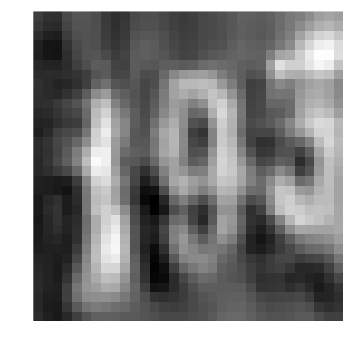

In [21]:
plt.axis('off')
plt.imshow(dataset[90], cmap=plt.cm.gray, interpolation='none')

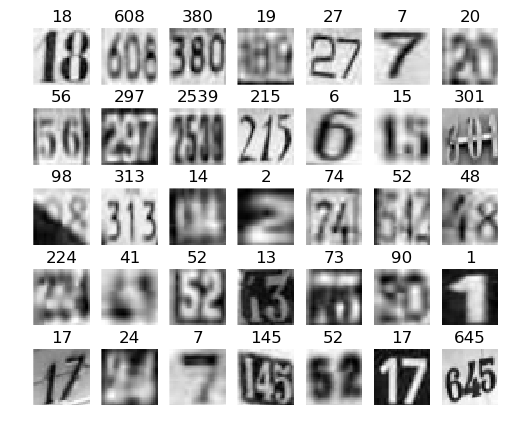

In [22]:
# Make sure image still look good
import random

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(6,5))
for ax in axes.flatten():
    random_idx = random.randint(0, dataset.shape[0]-1)
    ax.axis('off')
    ax.imshow(dataset[random_idx], cmap=plt.cm.gray, interpolation='none')
    ax.set_title( ''.join(map(str, labels[random_idx, 1:1+labels[random_idx,0]])) )

In [24]:
from six.moves import cPickle as pickle

In [25]:
dataset = {
    'dataset': dataset,
    'labels': labels
}

pickle_file = 'svhn_multi_' + dataset_type + '.pickle'
with open(pickle_file, 'wb') as f:
    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)

'1632'